# xEPA for Punts and Kickoffs
The main goal of this project is to isolate the impact that kickers and punters have by looking only at the trajectory of kickoffs and punts. This culminates in the  "xEPA" (Expected Expected Points Added) metric that predicts the EPA of the play at some point in time during the play. The models can be used to aid strategy, analyze individual plays, and rank players.

# Improved EPA Model
The outside data source I used for this project is nflfastR. After studying the implementation of the epa model used by nflfastR, (https://arxiv.org/pdf/1802.00998.pdf), I realized there were several improvements to the model that I wanted to make.

* Training the model only on data from 2016-2021.
* Utilizing a fully non-linear model.
* Including the number of timeouts available for each team.
* Accounting for the difference in average team quality at different field positions.
* Assessing the impact of safeties correctly.
* Removing weighting.

### Limiting Training Data Time Range (2016-2021)
In 2016, touchbacks on kickoffs were moved up to the 25 from the 20. This changed the average starting field position after a kickoff, thus impacting the expected number of points scored on the subsequent drive. The cleanest way to account for this change is to only train on data collected since the 2016 season. Once it was clear that a new EPA model was best suited to fill my needs, I decided to include additional modifications.

### Using XGBoost
Gradient-boosted decision tree algorithms represent the state-of-the-art for many tabular supervised learning problems. I wanted to apply the power of XGBoost to modelling expected points in NFL games, allowing the variables such as down, distance, field position, and time remaining to interact and have non-linear shapes, as well as allow for NULL values, such as the down on kickoffs. The following measures were taken to prevent overfitting: 
* The model was constrained monotonically on field position, down, and distance. 
* Hyperparameters were tuned using Bayesian Optimization, trading off the different types of XGBoost regularization. 
* All model predictions were made using game-grouped 5-fold cross-validation, so that no model ever included plays from the same game in both its training and test sets.
* Predictions were clipped so that they stayed within the bounds of empirical results in the best (1st and goal at the 1) and worst (4th down inside your own 5) situations.

### Including Timeouts
I included the timeouts available to each team in addition to time remaining, more accurately reflecting the game state. Timeouts were also monotonically constrained to increase expected points. Time remaining was included as the discretized logarithm of seconds remaining.

### Team Strength by Field Position
Existing EPA models do not account for worse offenses more often having the ball in the own territory, while better offenses more often have it in the red zone (the reverse is true of defenses). This means that some of the EPA from improved field position was a reflection of moving from data generated by bad teams to data generated by good teams. On a field-position flipping play, the magnitude of this effect is nearly 0.5 EPA.

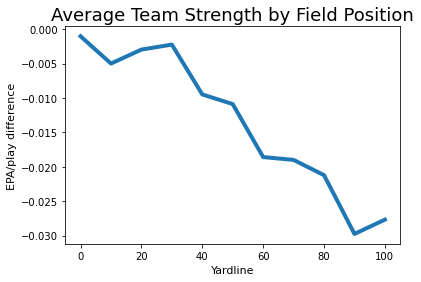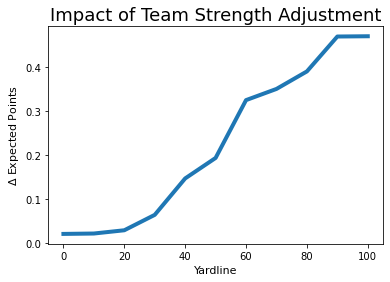

To solve this, I included a measure of offensive and defensive quality in my EPA model, and then set those features to league average when making predictions.

### Safeties
The same play follows both a touchdown and field goal: the scoring team kicks off from their own 35 (barring penalties). However, after a safety, the scoring team receives a free kick from the 25. Because of this, a safety is not a valid terminal play for the purposes of EPA calculation. Instead, you must keep going until either the half ends, or one team scores a touchdown or field goal, adding the safeties to whatever other points are scored. This increases the value of a safety from the perspective of the defense, with the average value of a safety changing from 1.0 to 3.5 EPA. This also impacts other plays where teams are backed up to their own end zone, such as after a particularly good punt.

### Weighting
I removed weighting by the number of drives until the subsequent score, because it biases punt values lower. Since a team receiving a punt is likely to score on the following drive, if the weight received by that score increases, then the expected points scored by that team will also increase. Conversely, this also means the the expected points of the punting team will decrease, causing an overly-negative EPA for the punt. Instead, I consider all scores within 6 drives equally. I also removed the weighting by score differential, instead only including plays where both teams had a >1% win probability.

# Punts
To isolate the value of a punt, I compare the EPA just before the punt, to the EPA right when the punt lands or is caught. By using the tracking data to identify this moment, we can remove the variance of snap, bounce, coverage, and return quality from the punt EPA estimate. This requires two models, one to estimate the pre-punt EPA and another to estimate the post-punt EPA. I only include punts that were not blocked.

### Pre-punt Model
The pre-punt model predicts the EPA of a punt play right before the punt occurs. This helps us control our estimate of punt quality for 2 crucial factors: coaches' decision making and snap quality. If a coach decides to punt the ball in a situation that will cost points, we should not blame the punter. Nor should the punter be held responsible for poor snaps. This model may also pick up on times when the punter had to rush the kick due to poor protection, but it is not explicitly designed to do so. Future versions of this model could use tracking data to include the minimum distance between a punter and an opposing player as a feature to capture this better.

Other than the EPA model, the rest of the models in this project are Generalized Additive Models. Instead of fitting straight lines, they fit polynomial splines, which allows it to model arbitrary functions. One advantage of these models is that they are easily interpretable, since you can add up contribution from each feature separately. 

The features considered by pre-punt EPA GAM model are:
* Punter's distance behind the line of scrimmage
* Punter's distance from the center of the field laterally
* Two estimates of Operation Time (time between the snap and the punt), one from PFF and the other from tagged events in the tracking data.
* Field Position
* Yards To Go
* PFF's SnapDetail

These features are used to predict the final EPA output of the EPA model for the play.

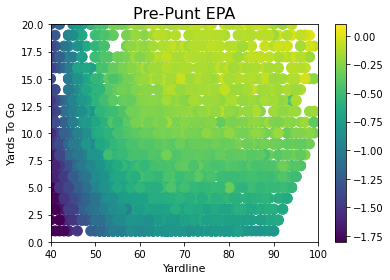

This plot shows the pre-punt EPA by field position and yards to go, the two most important features. Variation in the plot comes from changes in punter position and snap quality.

### Post-punt Model
The post-punt model predicts the EPA of a punt immediately after it hits the ground or is caught by the returner. Tracking data makes it possible to know this location with tracking events: `'punt_muffed', 'punt_land', 'fair_catch', 'punt_received', 'out_of_bounds', and 'touchback'`. Other sources of NFL play-by-play data only record the yardline where the ball is either downed or picked up by the return team, and we would like to separate the luck of bounces and the skill of returners and gunners from the punter's impact on EPA.

The features considered by post-punt EPA GAM model are:
* X-coordinate of the ball when the punt is caught or lands
* Y-coordinate of the ball when the punt is caught or lands
* Field position at the start of the play
* Distance from the line of scrimmage to the landing point (in the X-direction)
* Two estimates of the Hang Time, one from PFF and the other from the time between tagged events in the tracking data.

These features are once again used to predict the final EPA output of the EPA model for the play. The following plots were generated by imputing the hang time for each punt, given its starting field position and landing location, over a range of landing locations. The black line shows a contour of constant distance from the punter's initial punting location, assumed to be 10 yards behind the line of scrimmage in the center of the field.

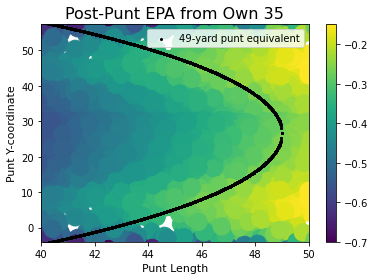

Here the punter wants to kick the ball as far as possible, because a touchback requires a 65-yard punt and results in a net 45-yard punt. While it does show that a punter can expect better results if the ball lands within 10 feet of the sideline, this requires the ball to travel a greater total distance. It is likely best to simply punt the ball straight downfield, although as long as the ball does not go out-of-bounds prematurely, differences in EPA are small for a given distance.

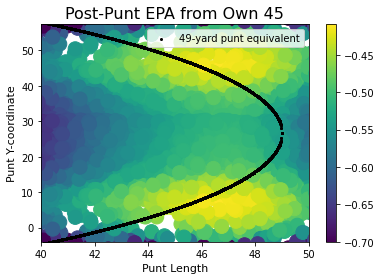

The punter still wants to kick the ball quite far, but must be wary of a touchback, which would be an undesirable result. It shows that the ideal result would be a punt landing 7-10 yards short of the endzone and within 10 yards of either sideline. This maximizes the chance for a fair catch or a downed ball within the 10, while minimizing the chance of a bad bounce that would result in a touchback.

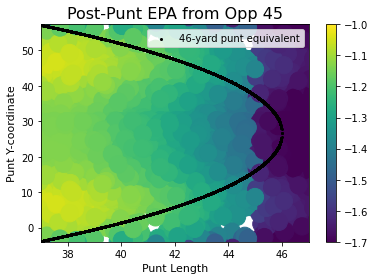

When punting inside the 50, avoiding a touchback is even more important and the post-punt EPA drops off quickly as the ball's landing location approaches the endzone. The ideal ball placement is roughly the same as the previous plot.

### Punt xEPA
To calculate Punt xEPA, simply subtract the prediction from the pre-punt EPA model from the post-punt EPA prediction. As a sanity check, the worst punt was a 15-yard punt from the 20, going out of bounds at the 35 with a Punt xEPA of -1.9. The best punt was a 56-yard punt from the 32 with a booming hang time of 5.8 seconds where the Punt xEPA was +1.2. We can also aggregate the results by punter. Here are the results for each punter with at least 50 punts from 2018-2020.

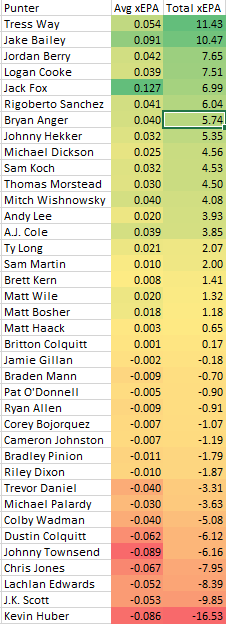


# Kickoffs
Kickoffs can be treated in a similar way to punts, except that they are simpler to analzye pre-kickoff, since barring penalties, all kickoffs start from the same spot. Instead of a pre-kickoff model, I normalized the average EPA of each kickoff starting location to 0. Only kickoffs classified by PFF as "Deep", "Flat", "Pooch" or "Deep Direct OOB" are included, since it is difficult to asses the quality of a squib or onside kick in the same way.

### Kickoff xEPA
Similar to the punt model, the kickoff model uses the tracking data to pinpoint the location and timing of the ball being caught or hitting the ground and calculate features. The features are fed into a GAM to predict the play's total EPA, normalized by starting field position. The features are:
* Kickoff End X-coordinate
* Kickoff End Y-coordinate
* Kickoff starting location
* Kickoff X-distance
* Hang Time, both from PFF and tracking data event times.

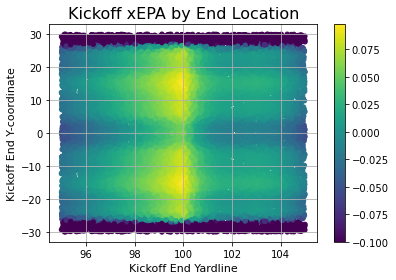

These model results indicate that the best place to land a kickoff is directly in front of the goal line, and it is better to kick the ball slightly away from tge middle of the field.

Aggregating the results by kickers with at least 50 kickoffs, we can also see who were the most and least effective kickers on kickoffs from 2018-2020.

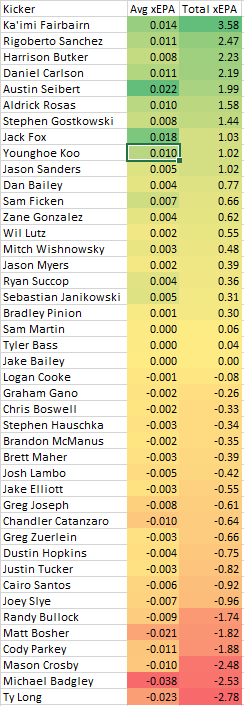

# Appendix
Code for this project can be found here: https://github.com/caldred/BDB2022_xEPA